# EcoSort Waste Management Assistant
# Module 8 Summative Lab

## Overview

You are a data scientist at "EcoSort," a technology company that specializes in developing AI solutions for waste management. EcoSort has partnered with Metro City's waste management department to develop an intelligent waste management assistant that can help residents properly dispose of waste items so less time is spent sorting material at facilities.

This assistant needs to:

1. Identify waste materials from images uploaded by residents (CNN)
2. Classify waste items based on text descriptions provided by residents (RNN/Transformer)
3. Generate specific recycling instructions based on identified waste type and city policies (Generative Transformer with RAG)

Your task is to build this integrated system using the RealWaste dataset along with generated text data that simulates real-world waste management operations.

In [1]:
# !pip install transformers sentence-transformers

In [2]:
import os
print(os.listdir('/content/'))

['.config', 'waste_policy_documents.json', 'waste_descriptions.csv', 'drive', 'sample_data']


## Part 1: Dataset Exploration and Preparation

In this section, you will explore and prepare the datasets for your models.

### 1.1 Load and Explore the RealWaste Dataset

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pathlib
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity

# TensorFlow / Keras functions
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Number of classes: 9
Class names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Total images: 4752

Per-class distribution:
  Cardboard: 461
  Food Organics: 411
  Glass: 420
  Metal: 790
  Miscellaneous Trash: 495
  Paper: 500
  Plastic: 921
  Textile Trash: 318
  Vegetation: 436


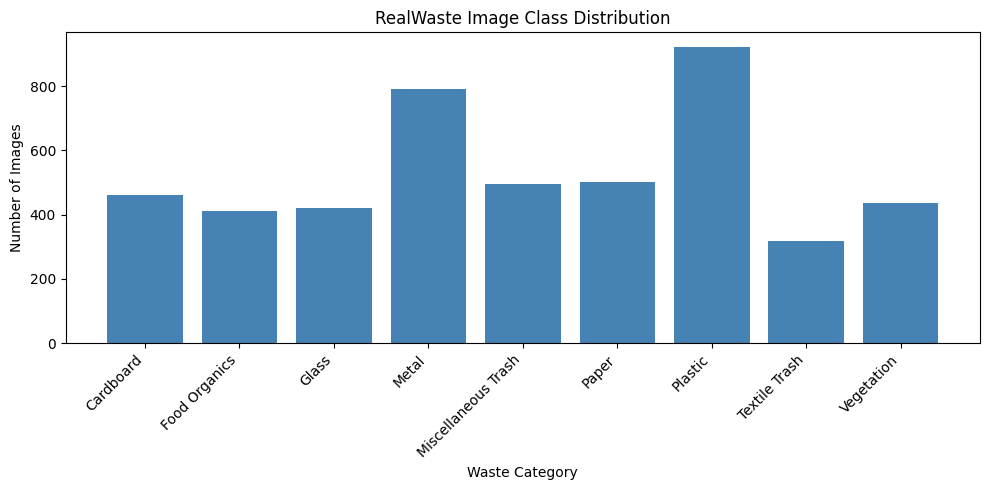

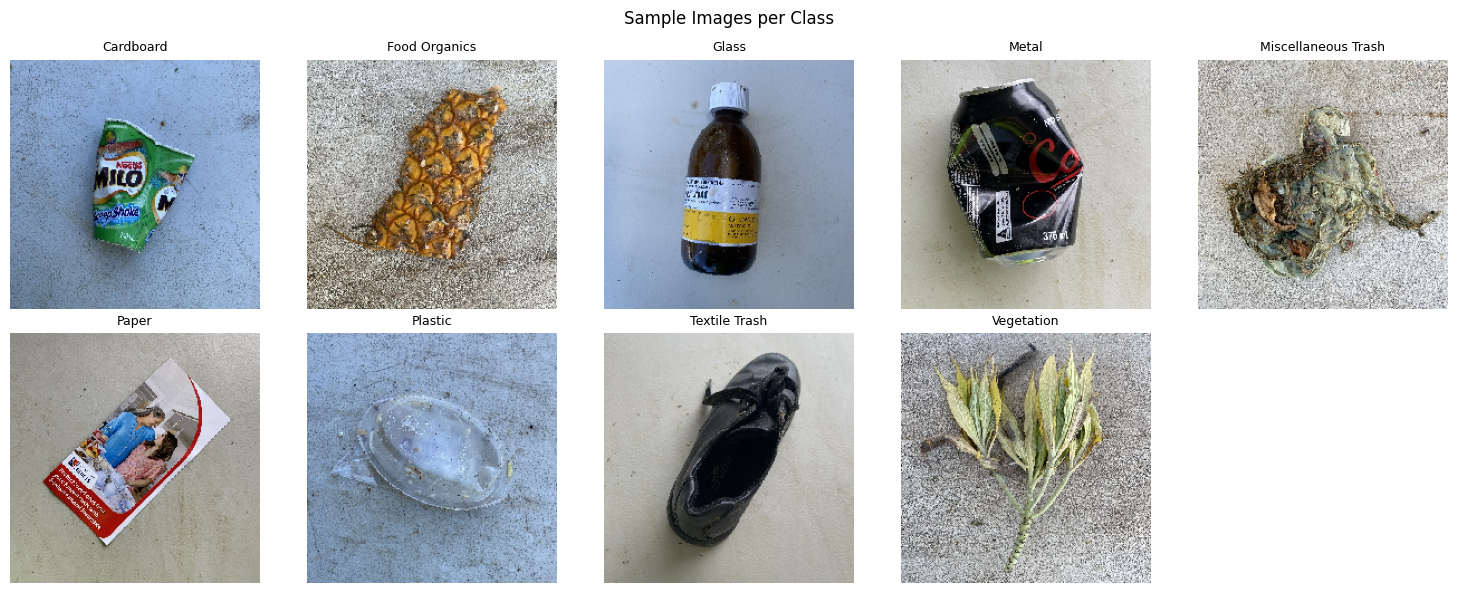

In [5]:
# TODO: Load and explore the RealWaste dataset
# - Dataset structure
# - Distribution of waste categories
# - Image characteristics (resolution, quality, background)

# Your code here
data_dir = pathlib.Path('/content/drive/MyDrive/RealWaste')

# Count classes and images
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
num_classes = len(class_names)
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png')))

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Total images: {image_count}")

# Per-class image counts
print("\nPer-class distribution:")
class_counts = {}
for cls in class_names:
    count = len(list((data_dir / cls).glob('*.jpg'))) + len(list((data_dir / cls).glob('*.png')))
    class_counts[cls] = count
    print(f"  {cls}: {count}")

# Bar chart of class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='steelblue')
plt.title('RealWaste Image Class Distribution')
plt.xlabel('Waste Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display a sample image from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, cls in enumerate(class_names):
    img_paths = list((data_dir / cls).glob('*.jpg')) + list((data_dir / cls).glob('*.png'))
    if img_paths:
        img = tf.keras.utils.load_img(img_paths[0], target_size=(224, 224))
        axes[i].imshow(img)
        axes[i].set_title(cls, fontsize=9)
        axes[i].axis('off')
# hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.suptitle('Sample Images per Class')
plt.tight_layout()
plt.show()

### 1.2 Explore Text Datasets

=== Waste Descriptions Dataset ===
Shape: (5000, 5)

Columns: ['description', 'category', 'disposal_instruction', 'common_confusion', 'material_composition']

Null values:
description                0
category                   0
disposal_instruction       0
common_confusion        2504
material_composition       0
dtype: int64

Category distribution:
category
Vegetation             600
Textile Trash          586
Cardboard              584
Miscellaneous Trash    578
Plastic                569
Glass                  551
Food Organics          518
Metal                  508
Paper                  506
Name: count, dtype: int64


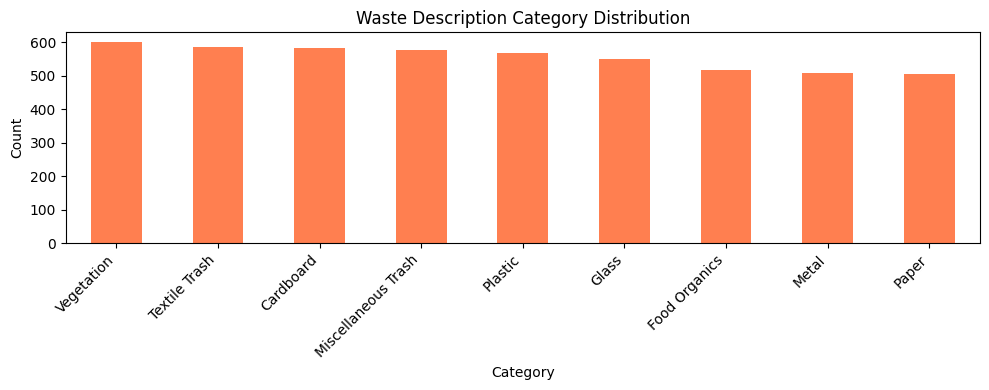


Description word count stats:
count    5000.000000
mean        4.854000
std         1.549956
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        10.000000
Name: desc_length, dtype: float64


In [6]:
# TODO: Load and explore the waste description text data
# - Load waste_descriptions.csv
# - Analyze vocabulary and structure
# - Understand the distribution of categories

# Your code here
waste_desc = pd.read_csv('waste_descriptions.csv')

print("=== Waste Descriptions Dataset ===")
print(f"Shape: {waste_desc.shape}")
print(f"\nColumns: {waste_desc.columns.tolist()}")
print(f"\nNull values:\n{waste_desc.isnull().sum()}")
print(f"\nCategory distribution:\n{waste_desc['category'].value_counts()}")

# Category bar chart
waste_desc['category'].value_counts().plot(kind='bar', figsize=(10, 4), color='coral')
plt.title('Waste Description Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Description length analysis
waste_desc['desc_length'] = waste_desc['description'].str.split().str.len()
print(f"\nDescription word count stats:\n{waste_desc['desc_length'].describe()}")

In [7]:
# TODO: Load and explore the waste policy documents
# - Load waste_policy_documents.json
# - Understand document organization and language

# Your code here
waste_policy = pd.read_json('waste_policy_documents.json')

print("\n=== Waste Policy Documents ===")
print(f"Number of documents: {len(waste_policy)}")
print(f"\nColumns: {waste_policy.columns.tolist()}")
print(f"\nPolicy types:\n{waste_policy['policy_type'].tolist()}")
print(f"\nCategories covered (sample):\n{waste_policy['categories_covered'].head()}")


=== Waste Policy Documents ===
Number of documents: 14

Columns: ['policy_id', 'policy_type', 'categories_covered', 'effective_date', 'document_text', 'jurisdiction']

Policy types:
['Textile Trash Recycling Guidelines', 'Glass Recycling Guidelines', 'Food Organics Recycling Guidelines', 'Plastic Recycling Guidelines', 'Vegetation Recycling Guidelines', 'Cardboard Recycling Guidelines', 'Metal Recycling Guidelines', 'Paper Recycling Guidelines', 'Miscellaneous Trash Recycling Guidelines', 'Municipal Waste Guidelines', 'Residential Recycling Rules', 'Commercial Recycling Standards', 'Multi-Unit Building Guidelines', 'Community Recycling Program']

Categories covered (sample):
0    [Textile Trash]
1            [Glass]
2    [Food Organics]
3          [Plastic]
4       [Vegetation]
Name: categories_covered, dtype: object


### 1.3 Create Data Pipelines

In [8]:
# Run this code to setup the images properly into train, validation, and test sets
# Set your data directory path - update this with your actual path
data_dir = pathlib.Path('/content/drive/MyDrive/RealWaste')

# Parameters
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Calculate the total number of classes automatically from the directory structure
num_classes = len([item for item in data_dir.glob('*') if item.is_dir()])
print(f"Number of classes: {num_classes}")

# List all class folders
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
print(f"Class names: {class_names}")

# Count all images
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png')))
print(f"Total images found: {image_count}")

# Create a dataset using tf.keras.utils.image_dataset_from_directory
# This will automatically split the data into training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

# Create a separate test dataset by taking part of the validation set
# First, let's get the number of batches in the validation set
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // 2)
validation_ds = validation_ds.skip(val_batches // 2)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_dataset)}")

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Number of classes: 9
Class names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Total images found: 4752
Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.
Number of training batches: 119
Number of validation batches: 15
Number of test batches: 15


In [9]:
# TODO: Create a text preprocessing pipeline
# - Tokenization
# - Text cleaning
# - Split data into train and test
# - Create embeddings/features

# Your code here
def clean_text(text):
    """Lowercase and remove special characters."""
    text = text.lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

# Apply cleaning
waste_desc['clean_description'] = waste_desc['description'].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
waste_desc['label'] = label_encoder.fit_transform(waste_desc['category'])

print("Label mapping:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"  {i}: {cls}")

# Train/test split (stratified to preserve class balance)
X = waste_desc['clean_description'].values
y = waste_desc['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Label mapping:
  0: Cardboard
  1: Food Organics
  2: Glass
  3: Metal
  4: Miscellaneous Trash
  5: Paper
  6: Plastic
  7: Textile Trash
  8: Vegetation

Training samples: 4000
Test samples: 1000


In [10]:
# TODO: Prepare documents for RAG
# - Document preprocessing
# - Create embeddings for retrieval

# Your code here
# Extract document texts and metadata for retrieval
policy_docs = waste_policy[['policy_id', 'policy_type', 'categories_covered', 'document_text']].copy()

# Each document becomes a retrievable chunk
doc_texts = policy_docs['document_text'].tolist()
doc_metadata = policy_docs[['policy_id', 'policy_type', 'categories_covered']].to_dict('records')

print(f"Documents prepared for retrieval: {len(doc_texts)}")
print(f"\nSample document preview:\n{doc_texts[0][:300]}...")

# Create embeddings using SentenceTransformer (used later in Part 4 for retrieval)
print("\nLoading sentence transformer model...")
embedder = SentenceTransformer('all-MiniLM-L6-v2')  # small, fast, good quality
doc_embeddings = embedder.encode(doc_texts, show_progress_bar=True)

print(f"\nEmbedding matrix shape: {doc_embeddings.shape}")
# shape should be (14, 384) — 14 documents, 384-dim embeddings

Documents prepared for retrieval: 14

Sample document preview:
TEXTILE RECYCLING GUIDELINES

Acceptable Items:
- Clean clothing (all conditions)
- Towels, sheets, and linens
- Fabric scraps
- Curtains and cloth napkins
- Handbags and backpacks made of fabric
- Soft toys and stuffed animals

Non-Acceptable Items:
- Wet or moldy textiles
- Heavily soiled items
- ...

Loading sentence transformer model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Embedding matrix shape: (14, 384)


## Part 2: Waste Material Classification with CNN

In this section, you will build a CNN model to classify waste materials from images.

### 2.1 Preprocess Images

In [11]:
# TODO: Implement image preprocessing
# - Apply the preprocessing pipeline created earlier

# Your code here

# Data augmentation + normalization pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
], name="data_augmentation")

# Normalization layer (scales pixels from [0,255] to [-1,1] — required by MobileNetV2)
normalization = tf.keras.layers.Rescaling(1./127.5, offset=-1)

print("Preprocessing pipeline ready.")
print("Augmentations: random horizontal flip, ±10% rotation, ±10% zoom")
print("Normalization: [0, 255] → [-1, 1]")

Preprocessing pipeline ready.
Augmentations: random horizontal flip, ±10% rotation, ±10% zoom
Normalization: [0, 255] → [-1, 1]


### 2.2 Implement CNN Model with Transfer Learning

In [12]:
# if notebook times out, reload saved model
# model = tf.keras.models.load_model('/content/drive/MyDrive/best_cnn_model.keras')
# print("CNN loaded from Drive.")

In [13]:
# TODO: Select an appropriate base model and implement transfer learning
# - Choose from MobileNet, EfficientNet, etc.
# - Add custom classification layers for the 9 waste categories
# - Configure loss function and metrics

# Your code here
IMG_HEIGHT, IMG_WIDTH = 224, 224
num_classes = 9

# Load MobileNetV2 as frozen base
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,   # remove the ImageNet classification head
    weights='imagenet'   # start with pretrained weights
)
base_model.trainable = False  # freeze all base layers for now

# Build the full model
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)       # augment during training
x = normalization(x)                # normalize to [-1, 1]
x = base_model(x, training=False)   # frozen feature extractor
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # flatten feature maps
x = tf.keras.layers.Dropout(0.3)(x)              # regularization
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 2.3 Train and Evaluate the Model

In [ ]:
# TODO: Train the CNN model
# - Use appropriate batch size and epochs
# - Implement regularization to prevent overfitting
# - Monitor training and validation metrics

# Your code here
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

print("Training with frozen base (transfer learning phase)...")
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=15,
    callbacks=[early_stop]
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.tight_layout()
plt.show()

Training with frozen base (transfer learning phase)...
Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.4293 - loss: 1.6856 - val_accuracy: 0.7149 - val_loss: 0.7750
Epoch 2/15
 48/119 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - accuracy: 0.6831 - loss: 0.8767

In [ ]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns

# Your code here

# Accuracy on test set
test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Confusion matrix
y_true, y_pred = [], []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.title('CNN Confusion Matrix')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-class accuracy:")
for i, cls in enumerate(class_names):
    class_acc = cm[i, i] / cm[i].sum()
    print(f"  {cls}: {class_acc:.2%}")

### 2.4 Fine-tune the Model

In [ ]:
# TODO: Tune model parameters to improve performance
# - Adjust learning rate
# - Add regularization, dropout
# - Modify architecture if needed

# Your code here
# Unfreeze the top layers of the base model for fine-tuning
base_model.trainable = True

# Only fine-tune the last 30 layers — keeps earlier general features frozen
for layer in base_model.layers[:-30]:
    layer.trainable = False

print(f"Trainable layers: {sum(1 for l in base_model.layers if l.trainable)} / {len(base_model.layers)}")

# Recompile with a much lower learning rate to avoid destroying pretrained weights
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop_ft = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

print("Fine-tuning...")
history_ft = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10,
    callbacks=[early_stop_ft]
)

# Re-evaluate after fine-tuning
test_loss_ft, test_acc_ft = model.evaluate(test_dataset, verbose=0)
print(f"\nFine-tuned Test Accuracy: {test_acc_ft:.4f}  (was {test_acc:.4f})")

In [ ]:
model.save('/content/drive/MyDrive/best_cnn_model.keras')
print("CNN saved to Drive.")

In [ ]:

# Accuracy on test set AFTER fine tuning
test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Confusion matrix
y_true, y_pred = [], []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.title('CNN Confusion Matrix')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-class accuracy:")
for i, cls in enumerate(class_names):
    class_acc = cm[i, i] / cm[i].sum()
    print(f"  {cls}: {class_acc:.2%}")

## Part 3: Waste Description Classification

In this section, you will build a text classification model to categorize waste based on descriptions.

### 3.1 Preprocess Text Data

In [ ]:
# TODO: Implement text preprocessing
# - Apply the text preprocessing pipeline created earlier

# Your code here
from transformers import AutoTokenizer
import tensorflow as tf

# Load DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_texts(texts, max_length=64):
    return tokenizer(
        list(texts),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='np'  # changed from 'tf' to 'np'
    )

# Tokenize train and test sets
print("Tokenizing training data...")
train_encodings = tokenize_texts(X_train)
print("Tokenizing test data...")
test_encodings = tokenize_texts(X_test)

# Convert labels to one-hot
num_text_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_text_classes)
y_test_cat = to_categorical(y_test, num_text_classes)

# Build TensorFlow datasets — numpy arrays work fine here
train_text_ds = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_encodings['input_ids'],
     'attention_mask': train_encodings['attention_mask']},
    y_train_cat
)).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_text_ds = tf.data.Dataset.from_tensor_slices((
    {'input_ids': test_encodings['input_ids'],
     'attention_mask': test_encodings['attention_mask']},
    y_test_cat
)).batch(32).prefetch(tf.data.AUTOTUNE)

print(f"\nTraining batches: {len(train_text_ds)}")
print(f"Test batches: {len(test_text_ds)}")
print(f"Classes: {list(label_encoder.classes_)}")

### 3.2 Implement Text Classification Model

In [ ]:
# TODO: Choose and implement a text classification model
# Option A: Traditional ML model (Naive Bayes, Random Forest, etc.)
# Option B: Fine-tune a transformer-based model (BERT, DistilBERT, etc.)

# Your code here
import torch
import torch.nn as nn
from transformers import AutoModel
from torch.utils.data import DataLoader, TensorDataset

# NOTE: TFAutoModel was removed in newer versions of transformers (4.x+).
# Switching to a pure PyTorch training loop avoids the brittle PyTorch/TensorFlow
# hybrid approach (tf.py_function) which caused gradient flow issues and
# model collapse (12% accuracy, predicting only 2 classes).
# Pure PyTorch ensures gradients flow correctly through the entire model.

class DistilBertClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained('distilbert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False
        self.dropout1 = nn.Dropout(0.3)
        self.dense = nn.Linear(768, 128)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        x = self.dropout1(cls_output)
        x = self.relu(self.dense(x))
        x = self.dropout2(x)
        return self.classifier(x)  # raw logits — CrossEntropyLoss expects these

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

text_model_pt = DistilBertClassifier(num_text_classes).to(device)

In [ ]:
def make_dataloader(encodings, labels, batch_size=32, shuffle=False):
    dataset = TensorDataset(
        torch.tensor(encodings['input_ids'], dtype=torch.long),
        torch.tensor(encodings['attention_mask'], dtype=torch.long),
        torch.tensor(labels, dtype=torch.long)
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = make_dataloader(train_encodings, y_train, shuffle=True)
test_loader  = make_dataloader(test_encodings,  y_test,  shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

### 3.3 Train and Evaluate the Model

In [ ]:
# TODO: Train the text classification model
# - Use appropriate training parameters
# - Monitor training progress

# Your code here
optimizer = torch.optim.Adam(text_model_pt.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()
early_stop_patience = 5
best_val_loss = float('inf')
patience_counter = 0

train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(20):
    # --- Train ---
    text_model_pt.train()
    total_loss, correct, total = 0, 0, 0
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = (
            input_ids.to(device), attention_mask.to(device), labels.to(device)
        )
        optimizer.zero_grad()
        logits = text_model_pt(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_train_loss = total_loss / len(train_loader)

    # --- Validate ---
    text_model_pt.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            input_ids, attention_mask, labels = (
                input_ids.to(device), attention_mask.to(device), labels.to(device)
            )
            logits = text_model_pt(input_ids, attention_mask)
            val_loss += criterion(logits, labels).item()
            val_correct += (logits.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / len(test_loader)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(text_model_pt.state_dict(), '/content/drive/MyDrive/best_text_model.pt')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Restore best weights
text_model_pt.load_state_dict(torch.load('/content/drive/MyDrive/best_text_model.pt'))
print("Restored best model weights.")

# Plot curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(train_accs, label='Train')
ax1.plot(val_accs, label='Validation')
ax1.set_title('Text Classifier Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax2.plot(train_losses, label='Train')
ax2.plot(val_losses, label='Validation')
ax2.set_title('Text Classifier Loss')
ax2.set_xlabel('Epoch')
ax2.legend()
plt.tight_layout()
plt.show()

In [ ]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns

# Your code here
# Evaluate
text_model_pt.eval()
y_true_text, y_pred_text = [], []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        logits = text_model_pt(input_ids, attention_mask)
        y_true_text.extend(labels.numpy())
        y_pred_text.extend(logits.argmax(1).cpu().numpy())

test_acc_text = (np.array(y_true_text) == np.array(y_pred_text)).mean()
print(f"Test Accuracy: {test_acc_text:.4f}")

cm_text = confusion_matrix(y_true_text, y_pred_text)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_text, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.title('Text Classifier Confusion Matrix')
plt.tight_layout()
plt.show()

print("\nPer-class accuracy:")
for i, cls in enumerate(label_encoder.classes_):
    class_acc = cm_text[i, i] / cm_text[i].sum()
    print(f"  {cls}: {class_acc:.2%}")

### 3.4 Create Classification Function

In [ ]:
# TODO: Create a function that takes a text description and returns the predicted waste category
def classify_waste_description(description):
    """
    Classifies a waste description into an appropriate category.

    Args:
        description (str): Text description of waste item
    Returns:
        tuple: (predicted_category, confidence)
    """
    text_model_pt.eval()
    cleaned = clean_text(description)
    encoding = tokenize_texts([cleaned])

    input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long).to(device)
    attention_mask = torch.tensor(encoding['attention_mask'], dtype=torch.long).to(device)

    with torch.no_grad():
        logits = text_model_pt(input_ids, attention_mask)
        probs = torch.softmax(logits, dim=1)
        predicted_index = probs.argmax(1).item()
        confidence = probs[0][predicted_index].item()

    predicted_category = label_encoder.inverse_transform([predicted_index])[0]
    return predicted_category, confidence

# Quick test
test_phrases = [
    "empty crushed aluminum soda can",
    "torn cardboard shipping box",
    "leftover rice and vegetable scraps",
    "worn out cotton t-shirt",
    "broken green wine bottle"
]

print("Testing classify_waste_description():\n")
for phrase in test_phrases:
    category, conf = classify_waste_description(phrase)
    print(f"  '{phrase}'")
    print(f"   → {category} ({conf:.2%} confidence)\n")

In [ ]:
# Compare to TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

tfidf_acc = lr_model.score(X_test_tfidf, y_test)
print(f"TF-IDF + Logistic Regression Accuracy: {tfidf_acc:.4f}")

## Part 4: Recycling Instruction Generation with RAG

In this section, you will implement a Retrieval-Augmented Generation (RAG) system to generate recycling instructions.

### 4.1 Preprocess Documents for Retrieval

In [ ]:
# TODO: Prepare documents for retrieval
# - Process policy documents and disposal instructions
# - Create embeddings for efficient retrieval

# Your code here

# Documents and embeddings were already created in Part 1 (Section 1.3c)
# This cell confirms they're ready and shows how retrieval will work

print("Documents available for retrieval:")
for i, meta in enumerate(doc_metadata):
    print(f"  [{i}] {meta['policy_type']} — covers: {meta['categories_covered']}")

print(f"\nEmbedding matrix shape: {doc_embeddings.shape}")
print("Ready for retrieval.")

In [ ]:
def retrieve_relevant_docs(query, top_k=2):
    """
    Retrieves the most relevant policy documents for a given query.

    Uses cosine similarity between the query embedding and all document
    embeddings to find the best matches.

    Args:
        query (str): Waste category or description
        top_k (int): Number of documents to retrieve
    Returns:
        list of dicts with keys: policy_type, categories_covered, document_text, score
    """
    # Embed the query using the same model as the documents
    query_embedding = embedder.encode([query])

    # Compute cosine similarity between query and all documents
    similarities = cosine_similarity(query_embedding, doc_embeddings)[0]

    # Get top_k most similar document indices
    top_indices = similarities.argsort()[::-1][:top_k]

    results = []
    for idx in top_indices:
        results.append({
            'policy_type': doc_metadata[idx]['policy_type'],
            'categories_covered': doc_metadata[idx]['categories_covered'],
            'document_text': doc_texts[idx],
            'score': similarities[idx]
        })
    return results

# Test retrieval
print("Testing retrieval:\n")
for query in ['Metal', 'Plastic', 'Food Organics']:
    docs = retrieve_relevant_docs(query, top_k=2)
    print(f"Query: '{query}'")
    for doc in docs:
        print(f"  → {doc['policy_type']} (score: {doc['score']:.4f})")
    print()

### 4.2 Implement RAG-based System

In [ ]:
# TODO: Select a pre-trained language model and implement RAG
# - Choose an appropriate language model
# - Create a retrieval mechanism

# Your code here
def retrieve_relevant_docs(query, top_k=2):
    """
    Retrieves the most relevant policy documents for a given query.

    Uses cosine similarity between the query embedding and all document
    embeddings to find the best matches.

    Args:
        query (str): Waste category or description
        top_k (int): Number of documents to retrieve
    Returns:
        list of dicts with keys: policy_type, categories_covered, document_text, score
    """
    # Embed the query using the same model as the documents
    query_embedding = embedder.encode([query])

    # Compute cosine similarity between query and all documents
    similarities = cosine_similarity(query_embedding, doc_embeddings)[0]

    # Get top_k most similar document indices
    top_indices = similarities.argsort()[::-1][:top_k]

    results = []
    for idx in top_indices:
        results.append({
            'policy_type': doc_metadata[idx]['policy_type'],
            'categories_covered': doc_metadata[idx]['categories_covered'],
            'document_text': doc_texts[idx],
            'score': similarities[idx]
        })
    return results

# Test retrieval
print("Testing retrieval:\n")
for query in ['Metal', 'Plastic', 'Food Organics']:
    docs = retrieve_relevant_docs(query, top_k=2)
    print(f"Query: '{query}'")
    for doc in docs:
        print(f"  → {doc['policy_type']} (score: {doc['score']:.4f})")
    print()

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# DistilGPT-2 is a lightweight generative model — small enough for Colab
# and sufficient for structured instruction generation given a policy context
print("Loading DistilGPT-2...")
gen_tokenizer = AutoTokenizer.from_pretrained('distilgpt2')
gen_model = AutoModelForCausalLM.from_pretrained('distilgpt2')
gen_model.eval()

# Set pad token (GPT-2 doesn't have one by default)
gen_tokenizer.pad_token = gen_tokenizer.eos_token

print("DistilGPT-2 loaded.")

In [ ]:
def generate_recycling_instructions(waste_category):
    """
    Generates detailed recycling instructions for a given waste category
    using Retrieval-Augmented Generation (RAG).

    Steps:
        1. Retrieve most relevant policy documents via cosine similarity
        2. Build a prompt that injects the retrieved context
        3. Generate instructions using DistilGPT-2

    Args:
        waste_category (str): Waste category (e.g. 'Metal', 'Plastic')
    Returns:
        tuple: (generated_instructions str, retrieved_docs list)
    """
    # Step 1: Retrieve relevant documents
    retrieved_docs = retrieve_relevant_docs(waste_category, top_k=2)

    # Step 2: Build context from retrieved documents
    context = ""
    for doc in retrieved_docs:
        # Use first 400 chars of each doc to keep prompt manageable
        context += doc['document_text'][:400] + "\n\n"

    # Step 3: Build prompt
    prompt = (
        f"Based on the following recycling policy:\n\n"
        f"{context}"
        f"Provide recycling instructions for: {waste_category}\n"
        f"Instructions:"
    )

    # Step 4: Tokenize and generate
    inputs = gen_tokenizer(
        prompt,
        return_tensors='pt',
        max_length=512,
        truncation=True
    )

    with torch.no_grad():
        output_ids = gen_model.generate(
            inputs['input_ids'],
            max_new_tokens=100,
            do_sample=True,
            temperature=0.7,      # lower = more focused, higher = more creative
            top_p=0.9,            # nucleus sampling — keeps output coherent
            repetition_penalty=1.3,  # discourages repeating the same phrases
            pad_token_id=gen_tokenizer.eos_token_id
        )

    # Decode only the newly generated tokens (not the prompt)
    generated_tokens = output_ids[0][inputs['input_ids'].shape[1]:]
    instructions = gen_tokenizer.decode(generated_tokens, skip_special_tokens=True)

    return instructions.strip(), retrieved_docs

### 4.3 Adjust and Evaluate the System

In [ ]:
# TODO: Train the RAG-based system
# - Adjust sampling methods/parameters

# Your code here

# Test across all 9 waste categories
test_categories = [
    'Cardboard', 'Food Organics', 'Glass', 'Metal',
    'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation'
]

print("RAG System Evaluation\n" + "="*50)
for category in test_categories:
    instructions, retrieved_docs = generate_recycling_instructions(category)
    print(f"\nCategory: {category}")
    print(f"Retrieved: {[d['policy_type'] for d in retrieved_docs]}")
    print(f"Generated instructions:\n  {instructions}")
    print("-" * 50)

In [ ]:
# TODO: Evaluate the quality of generated instructions
# - Test with various waste categories
# - Assess relevance and accuracy

# Your code here

### 4.4 Create Instruction Generation Function

In [ ]:
# TODO: Create a function that takes a waste category and generates recycling instructions

def generate_recycling_instructions(waste_category):
    """
    Generates detailed recycling instructions for a given waste category.

    Args:
        waste_category (str): Waste category

    Returns:
        str: Detailed recycling instructions
        list: Relevant policy documents
    """
    # Your code here
    pass

## Part 5: Integrated Waste Management Assistant

In this section, you will integrate all three models into a unified waste management assistant.

### 5.1 Design Integration Architecture

In [ ]:
# TODO: Design an architecture that integrates all three models
# - Create interfaces between components
# - Handle input/output flow

# Your code here

### 5.2 Implement Integrated Assistant

In [ ]:
# TODO: Implement the integrated waste management assistant

def waste_management_assistant(input_data, input_type="image"):
    """
    Integrated waste management assistant that processes either images or text descriptions
    and returns waste classification and recycling instructions.

    Args:
        input_data: Either an image file path/array or a text description
        input_type (str): Type of input - "image" or "text"

    Returns:
        dict: Dictionary containing waste category, confidence, and recycling instructions
    """
    # Your code here
    pass

### 5.3 Evaluate the Integrated System

In [ ]:
# TODO: Evaluate the integrated system on test cases
# - Test with images from test dataset
# - Test with text descriptions from test dataset
# - Assess overall performance

# Your code here

## Submission Guidelines

1. Make sure all code cells are properly commented and annotated
2. Ensure that all functions are implemented and working correctly
3. Verify that all evaluation metrics are calculated and analyzed
4. Double-check that the integrated system works as expected
5. Submit your completed and annotated Jupyter notebook file

Remember to demonstrate your understanding of the underlying concepts and provide justification for your design decisions throughout the notebook.